# 1. Motivation

## Dataset
We chose to work with the Harry Potter wikia dataset http://harrypotter.wikia.com/wiki/Main_Page. The dataset holds just about all information there is for the Harry Potter movies. This includes everything from characters to plants and spells present in the movies. A part from the Wikia we also used the transcripts for the movies. These we could find on the transcript Wikia http://transcripts.wikia.com/wiki/Category:Harry_Potter_Transcripts, and contains everything that was said in the movies.

## Why?
We both grew up with Harry Potter and therefore found it obvious to try and analyze the Harry Potter Wikia. That way we could maybe for relations or connection that we new nothing about before, or just in general get a better idea of how everything in the Harry Potters universe actually fits together. We also thought that the website would appeal to many other people with the same interest in Harry Potter as us.

We also chose Harry Potter Wikia because it is easily accesible and it is possible to do varies amount of analysis. There are 8 Harry Potter movies, plenty of characters, many different places and more. All these things makes 

## Goal
The goal for the project is to show how interesting Graph theroy can be when it is used on something very mainstream. The website is a very tangible way for anybody to show the possiblities with these tools. We also hope to show with the transcripts that the movies highlights can be found, and that there might be a difference in the language as the movies progress.

With these tools we also hope to find relations that we otherwise would not have noticed without actually analyzing the data.

# 2. Basic stats
## Imports for whole project

In [1]:
import urllib2
import json
import io
import pandas as pd
import numpy as np
import math
import re
import os
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import nltk
import mwparserfromhell
import community
import networkx as nx
from fa2 import ForceAtlas2
import random
%matplotlib inline
plt.style.use('ggplot')

## Data extraction and cleaning

### Harry Potter Wikia
We extract all our data directly from the the Wikia sites. We start by getting the characters from the Harry Potter Wikia. We do this by querying the subcategory called "Categorymember". This category holds all the different characters. The characters that we actually want to analyze are the ones from Gryffindor, Hufflepuffs, Ravenclaws, Slytherins and Unknown. As we query the characters we make sure to save their name from the url and what house they are from in a panda dataframe. We then export this to a ".csv" file. We now have a ".csv" file that makes it easy for us look up all the characters wiki pages.

In [42]:
basequery = 'http://harrypotter.wikia.com/api.php?action=query&format=json&cmlimit=500'

houses = ['Category:Gryffindors', 
          'Category:Hufflepuffs', 
          'Category:Ravenclaws', 
          'Category:Slytherins', 
          'Category:Unknown_House']

def create_query(params):
    return basequery+'&' + '&'.join(params)

def create_subcategory_query(cmtitle):
    return create_query(['list=categorymembers', 'cmtitle='+cmtitle, 'cmtype=subcat'])

def create_page_query(cmtitle):
    return create_query(['list=categorymembers', 'cmtitle='+cmtitle, 'cmtype=page'])

# It returns all the sub categories that is found inside the different houses (Gryffindor, etc.)
# We use these to look up all the different sub categories to get names of the characters in the houses
def get_sub_categories(title):
    try:
        query = create_subcategory_query(title)
        query = query.replace(' ', '%20')
        response =  urllib2.urlopen(query)
    except Exception as e:
        print(e)
        print(query)
        return [title]
    response_dict = json.loads(response.read())
    if 'query' not in response_dict:
        return [title]
    return [title] + [c for d in response_dict['query']['categorymembers'] \
                      for c in get_sub_categories(d['title'])]

In [65]:
# Extracting the name and house for all the characters in a dataframe, and then exported to a ".csv" file.
pages = []
count = 0

for house in houses:
    # All sub categories of the house returned
    cs = get_sub_categories(house)
    for c in cs:
        # Getting the characters in the subcategory
        query = create_page_query(c)
        query = query.replace(' ', '%20')
        response =  urllib2.urlopen(query)
        
        # Retrieving the characters in the query and saving them
        response_dict = json.loads(response.read())
        for p in response_dict['query']['categorymembers']:
            if 'User:' in p['title'] or 'Template:' in p['title']: continue
            pages.append((p['pageid'], p['title'], house.split(':')[1]))
            
df = pd.DataFrame(np.transpose([[p[0] for p in pages], 
                   [p[1] for p in pages], 
                   [p[2] for p in pages]]), 
                  columns=['page_id', 'title', 'House'])
#df.to_csv('character.csv')

Now that the character csv file is created, it easy to load in the characters names and houses at any point. 

In [73]:
df = pd.read_csv('./character.csv')

We then use the all the characters names to query their wiki pages and save them in ".json" format. This way it easy to load in the data at any point. We name the files after what id that had when we created the character.csv. 

In [67]:
basequery = 'http://harrypotter.wikia.com/api.php?action=query&format=json&prop=revisions&rvprop=content'

def create_query_1(pageid):
    return basequery+'&pageids='+str(pageid)

def format_filename(name):
    return os.path.join('data/%s.json') % (name)

def dump_file(name, data):
    file_name = format_filename(name)
    with io.open(file_name, "w", encoding="utf-8") as f:
        f.write(unicode(json.dumps(data, ensure_ascii=False)))

In [74]:
for pageid in df['page_id']:
    query = create_query_1(pageid)
    response =  urllib2.urlopen(query)
    response_dict = json.loads(response.read())
    for k in response_dict['query']['pages'].keys():
        dump_file(pageid, response_dict['query']['pages'][k]['revisions'][-1]['*'])

As of right now we do not need to clean the pages up further, because we want to look for links to other characters to build a graph showing the whole network of Hogwarts. The clean up will be done in the Sentiment analysis where we actaully look directly at what is written on the wiki pages.

If we take a closer look at the data we have collected, there is a few characters that are not really "characters". The reason for this is that Harry Potter Wikia is community based, and that means the community create the articles and they might categorize them incorrectly. It is only a very small percentage of the characters that are not really characters. We have done our best in trying to remove them, but they might still be present. The only way we could do it was manually so it is not perfect.

### Transcipts
Apart from collecting the characters from Harry Potter Wikia we also have the transcripts for the movies, that are collected from another website. The transcripts are collected by querying the categories from the Harry Potter transscripts. This return a list of all the movies. We then uset his list to get all the specific transcripts. The transcripts needs to be cleaned before used for analysis. The methods below are used for creating the query to get the plain text from the Transcripts Wikia. The second method is used for cleaning out all the unnecessary symbols and data in the transcript. This includes stopwords, symbols and more. There is one movie that is not entered in the Transcripts Wikia. This movie transcipts is found in another place and copied in to a ".txt" file.

In [2]:
rvprop ="rvprop=timestamp|content"
rvdir = "rvdir=older" #sort revisions from newest to oldest
limit = "rvlimit=1" #consider only the first revision
def returnTitleQuery(title):
    replaceSpace = title.replace(" ", "_")
    return url + "&titles=" + replaceSpace + "&" + rvprop + "&" + rvdir + "&" + limit

tokenizer = RegexpTokenizer(r'\w+')
stopword_list = stopwords.words('english')

def clean_transcripts(movie_transcripts):
    # Remove markup that does not matter
    movie_transcripts = re.sub(r'(\{\{.*\}\}|\[.*\]|\n|\<\/p\>|\#.*\#|\(.W \)|\w+:|\<.*\>)','', movie_transcripts)
    movie_transcripts = movie_transcripts.lower()
    tokens = tokenizer.tokenize(movie_transcripts)
    tokens = [w for w in tokens if w not in stopword_list]
    return [w for w in tokens if w.isalpha()]

In [3]:
#Fetching the movie titles from the transcript Wiki
url = "https://transcripts.wikia.com/api.php?action=query&prop=revisions&format=json"
query = "&list=categorymembers&cmtitle=Category:Harry_Potter_Transcripts"
response =  urllib2.urlopen(url + query)
response_dict_categories = json.loads(response.read())

In [13]:
transcript_dict = {}
transcript_not_clean = {}
allmovies = []
movieTitles = ["Harry Potter and the Philosopher's Stone",
               'Harry Potter and the Chamber of Secrets',
               'Harry Potter and the Prisoner of Azkaban',
               'Harry Potter and the Goblet of Fire',
               'Harry Potter and the Order of the Phoenix',
               'Harry Potter and the Half-Blood Prince',
               'Harry Potter and the Deathly Hallows: Part 1',
               'Harry Potter and the Deathly Hallows: Part 2']

for movie in response_dict_categories["query"]["categorymembers"]:
    queryMovie = returnTitleQuery(movie["title"])
    response =  urllib2.urlopen(queryMovie)
    json_format = json.loads(response.read())
    response_dict = json_format
    for k in response_dict['query']['pages'].keys():
        if movie["title"] == "Harry Potter and the Goblet of Fire":
            fi = open("files/"+movie["title"] + ".txt", "r")
            text = fi.read()
            transcript_dict[movie["title"]] = clean_transcripts(text)
            allmovies = allmovies + transcript_dict[movie["title"]]
            transcript_not_clean[movie["title"]] = text
        else:
            transcript_not_clean[movie["title"]] = response_dict['query']['pages'][k]['revisions'][-1]['*']
            transcript_dict[movie["title"]] = clean_transcripts(response_dict['query']['pages'][k]['revisions'][-1]['*'])
            allmovies = allmovies + transcript_dict[movie["title"]]

The result is two dictionaries. Both of them have the movie titles as key. The item is for one them the cleaned transcripts and for the other one is the not cleaned transcripts. MovieTitles I have hard coded so that I can get the movies in chronological order. When retrieving directly from  the transcripts website it comes in alphabetical order.

### Basic data
In this section we will go through some basic methods for describing our data. We will start by creating a graph directed graph describing how the different characters are related. Here we use a regular expression to find all the links on the characters wiki pages link to another characters wiki page. The links are inside \[\[Link\]\]. 

In [75]:
regex = "\[\[(.*?)\]\]"

character_name = np.array(df.title)

G = nx.DiGraph()
for index, row in df.iterrows():
    G.add_node(row['title'], house=row['House'], pageid=row['page_id'])

for index, row in df.iterrows():
    with io.open(format_filename(row['page_id']), 'r', encoding='utf-8') as f:
        content = json.load(f)
    links = re.findall(regex, content)
    
    for link in links:
        for l in link.split('|'): 
            if l in character_name:
                G.add_edge(row['title'], l)

In [76]:
print("There are {} nodes in the whole graph.".format(len(G.nodes)))
print("There are {} edges in the whole graph.".format(len(G.edges)))

There are 855 nodes in the whole graph.
There are 4589 edges in the whole graph.


As can be seen from the output it is quite a big graph with a lot of nodes and edges. We will not try and show the graph in readable way. We do this by utilizing forceatlas that helps by calculating positions for the nodes, so they are placed nicely. We also make sure to color the nodes in the colors of the different houses.

In [71]:
def calculate_position(G):
    forceatlas2 = ForceAtlas2(scalingRatio=1.0,
                              strongGravityMode=False,
                              gravity=50.0,
                              verbose=False)
    return forceatlas2.forceatlas2_networkx_layout(nx.Graph(G), pos=None, iterations=3000)

In [72]:
house_color_dict = {
    'Gryffindors': '#740001',
    'Hufflepuffs': '#ecb939',
    'Slytherins': '#3d6b58',
    'Ravenclaws': '#222f5b',
    'Unknown_House': 'gray'
}

positions = calculate_position(G)
node_degree = [G.degree(n)*0.8+1 for n in G.nodes]
node_colors = [house_color_dict[v['house']] for k, v in G.nodes.data()]

In [146]:
# Add position, color and size as node attributes to dump it as GEXF file
for k, v in G.nodes(data=True):
    G.nodes[k]['x'] = positions[k][0]
    G.nodes[k]['y'] = positions[k][1]
    G.nodes[k]['color'] = house_color_dict[v['house']]
    G.nodes[k]['size'] = G.degree(k)*0.8+1

nx.write_gexf(G, os.path.join("docs", "resources", "graph.gexf"))

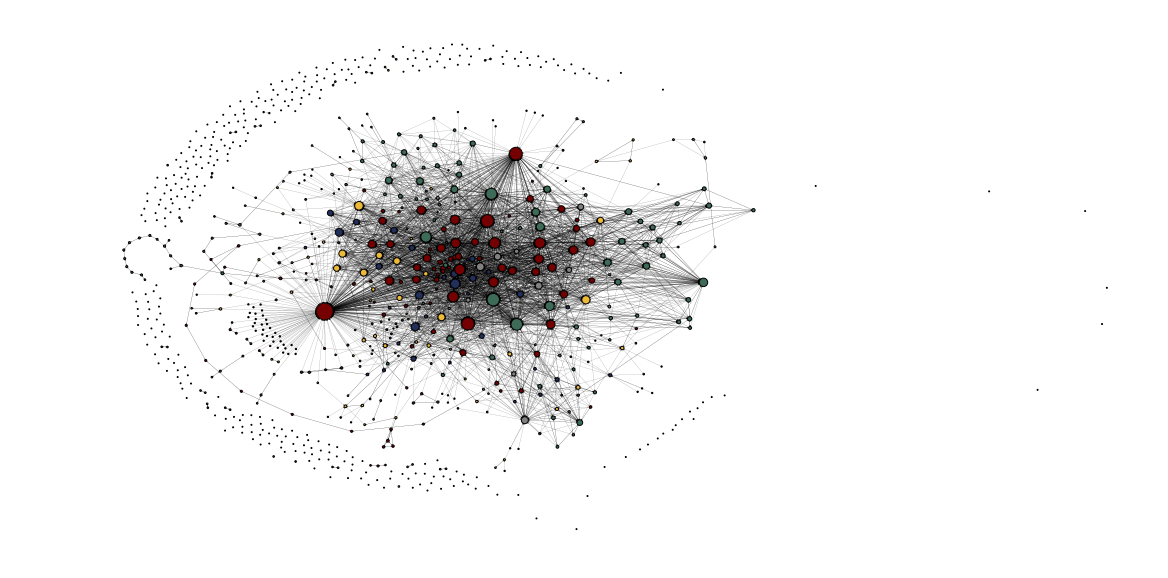

In [64]:
plt.figure(figsize=(20,10))
nx.draw_networkx(G, positions, 
                 cmap=plt.get_cmap('jet'), 
                 node_size=node_degree, 
                 node_color=node_colors, 
                 arrows = True,
                 width = 0.1,
                 with_labels=False,
                 linewidths=1., 
                 arrowsize=2)
plt.gca().collections[0].set_edgecolor("#000000")
plt.axis('off')
plt.show()

The biggest red cir .We can now take a look of how the out and in degree distribution looks for the same graph.

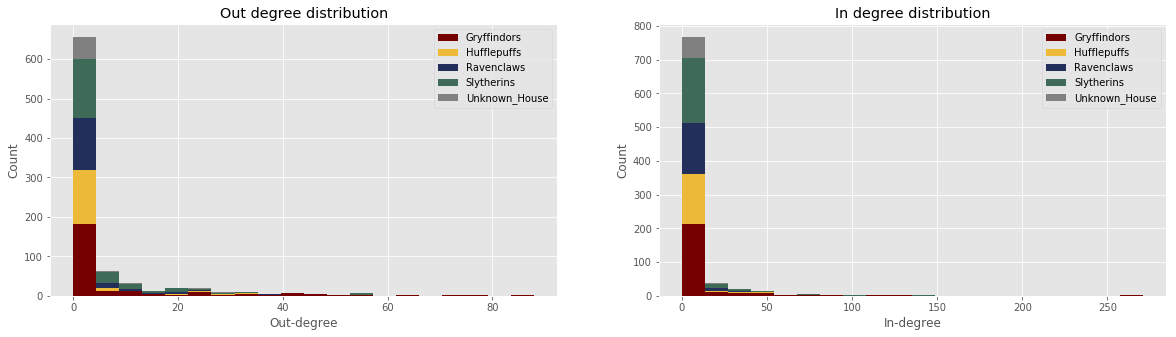

In [132]:
color_list = [v for h, v in house_color_dict.iteritems()]

in_degrees = [sorted([G.in_degree(k) for k, v in G.nodes.data() if v['house'] == h], reverse=True) \
              for h, _ in house_color_dict.iteritems()]
out_degrees = [sorted([G.out_degree(k) for k, v in G.nodes.data() if v['house'] == h], reverse=True) \
              for h, _ in house_color_dict.iteritems()]

plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(out_degrees, bins = 20, stacked=True, color=color_list)
plt.title('Out degree distribution')
plt.xlabel('Out-degree')
plt.ylabel('Count')
plt.legend(house_color_dict)
plt.subplot(122)
plt.hist(in_degrees, bins = 20, stacked=True, color=color_list)
plt.title('In degree distribution')
plt.xlabel('In-degree')
plt.ylabel('Count')
plt.legend(house_color_dict)

Text(0.5,1,'In degree - log scale')

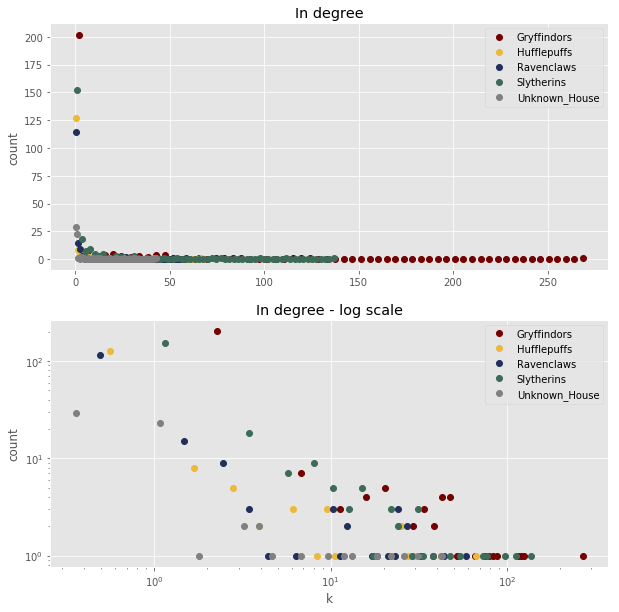

In [78]:
hists = [np.histogram(i, 60) for i in in_degrees]
plt.figure(figsize=(10,10))
plt.subplot(2,1,1)
for i, h in enumerate(hists):
    plt.plot(np.diff(h[1]) / 2 + h[1][:-1] , h[0], 'o', color=color_list[i])
plt.ylabel("count")
plt.title('In degree')
plt.legend(house_color_dict)
plt.subplot(2,1,2)
plt.xlabel("k")
plt.ylabel("count")
for i, h in enumerate(hists):
    plt.loglog(np.diff(h[1]) / 2 + h[1][:-1] , h[0], 'o', color=color_list[i])
plt.legend(house_color_dict)
plt.title('In degree - log scale')


Our network does not seem to follow the power law (Thomas skriv noget til det her)

In [131]:
all_in_degree = sum(in_degrees, [])
all_out_degree = sum(out_degrees, [])
# Gets the average and median degrees (the average is the same for in- and out-degrees obviously)
print("Average Degree = " + str(np.average(all_in_degree)))
print("Median In-degree = " + str(np.median(all_in_degree)))
print("Median Out-degree = " + str(np.median(all_out_degree)))
print("Highest In-degree = " + str(max(all_in_degree)))
print("Highest Out-degree = " + str(max(all_out_degree)))

Average Degree = 5.367251461988304
Median In-degree = 0.0
Median Out-degree = 1.0
Highest In-degree = 271
Highest Out-degree = 88


Here can be seen some of the basic statistics for the graph. One of the most interesting things is the the highest in-degree is substantially bigger then the highest out-degree. In this case it makes sense because the most important character probably is known by a lot more people than he actaul knows. When comparing the median to the average degree there something interesting is shown. Distance between the in-degree median and the average degree is large. The same goes for the out-degree. For the in-degree it means that more than 50% of the nodes has no ingoing edges. For the out-degree it means more than 50% has one or less out going edges. 

In general the small nodes probably links to the bigger nodes (example the main character), and they do not link back. This means that the out-degree is larger than the in-degree on an average node. The in-degree is only large on a few of the very important characters. 

This can also be seen by checking the correlation between the in and out-degree.

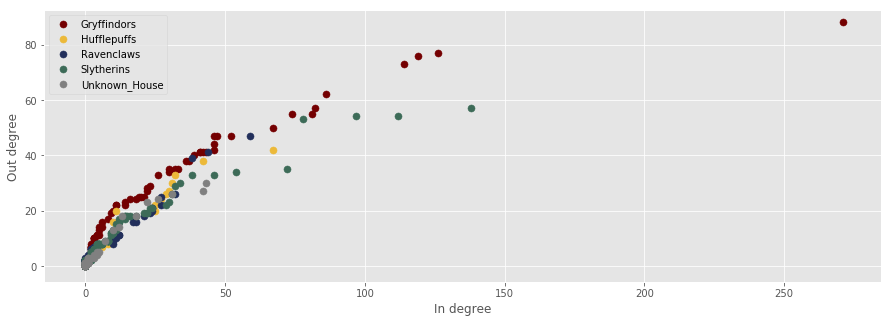

In [79]:
fig = plt.figure(figsize=(15,5))
ax = fig.add_subplot(111)
for i, c in enumerate(house_color_dict.itervalues()):
    scatter = ax.scatter(in_degrees[i], out_degrees[i], c=color_list[i],s=50)
plt.xlabel('In degree')
plt.ylabel('Out degree')
plt.legend(house_color_dict)

In [92]:
print("Correlation: " +str(np.corrcoef(sum(in_degrees, []),sum(out_degrees,[]))[0,1]))

Correlation: 0.9112134031304621


The corralation between the in and out degree is 0.91 which is really good. As mentioned before this is also what we can observe from the plot. This correaltion means that people with a high in degree tends to also have a high out degree. 

An interesting fact about the power law is the friendship paradox. It states that on average your friends have more friends than you. Even though our network does not seem the follow the power law we can do this check to make sure.

In [141]:
def friendship_paradox(G):
    results = []
    for _ in range(1000):
        node = random.choice(G.nodes.keys())
        nb_degrees = [G.degree(n) for n in G.neighbors(node)]
        results.append(G.degree(node) < np.mean(nb_degrees))
    result = np.sum(results)/float(1000)
    return result*100

In [144]:
friendship_paradox(G)

50.9

As we could also see from the plot the our graph does not seem the follow the power law at all. This can be conluded from the fact that it does not follow the rule of friendship paradox explained above.

# 3. Analysis


## Sentiment analysis

### Clean up
Now we have all the content on the wiki pages. The only problems is Harry Potter Wikia do not have the option of querying without all the media wiki markup. We do not care about the markup and just want the plain text top look at. Therefore we have downloaded the tool mwparserfromhell (https://github.com/earwig/mwparserfromhell) to help us remove all the markup easily. 


## Transcripts

In this section of the notebook we will go trought the Harry Potter transcripts from the movies. The analysis will be mostly of the langauges sentiment, and what different words are used. The words will used the most will be found with tf-idf and displayed in a readably way with wordclouds. The sentiment analysis will be done on the transcripts for each movie and will show case how the language changes over time.

In [5]:
def calculate_tfidfs(words1, words2):
    word1_set = set(words1)
    word2_set = set(words2)
    
    tf1 = nltk.FreqDist(words1)
    tf2 = nltk.FreqDist(words2)
    
    idf1 = {w: math.log(2.) for w in word1_set if w not in word2_set}
    idf2 = {w: math.log(2.) for w in word2_set if w not in word1_set}
    
    tfidf1 = {w: idf1[w]*tf1[w] for w, v in idf1.iteritems()}
    tfidf2 = {w: idf2[w]*tf2[w] for w, v in idf2.iteritems()}
    return tfidf1, tfidf2

def draw_word_cloud(words, collected_words, t_string):
    words_tfidf, collected_words_tfidf = calculate_tfidfs(words, collected_words)

    words_list = [k for k, _, in words_tfidf.iteritems() for _ in range(int(math.ceil(words_tfidf[k])))]
    random.shuffle(words_list)
    
    wordcloud = WordCloud(height= 720, width=1080, colormap="Blues").generate(' '.join(words_list))
    plt.figure(figsize=(15,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title("Worcloud TF-IDF for " + t_string)

First part of getting the movies transcript from Wikia, is to get the categories (movies titles), so we can properly query them.

### Word clouds

With the transcripts downloaded as explained in in the second chapter, it is now possible to do our different analysis. The first is setting up the words clouds for the movies. As part of getting a correctly and move reprensentative wordcloud we choose to create wordclouds based on tf-idf. Tf-idf was explained earlier on in project so will not be repeated. Tf-idf is actaully calculated inside of the draw wordcloud function, so is therefore not explictly called in other places then inside the function.

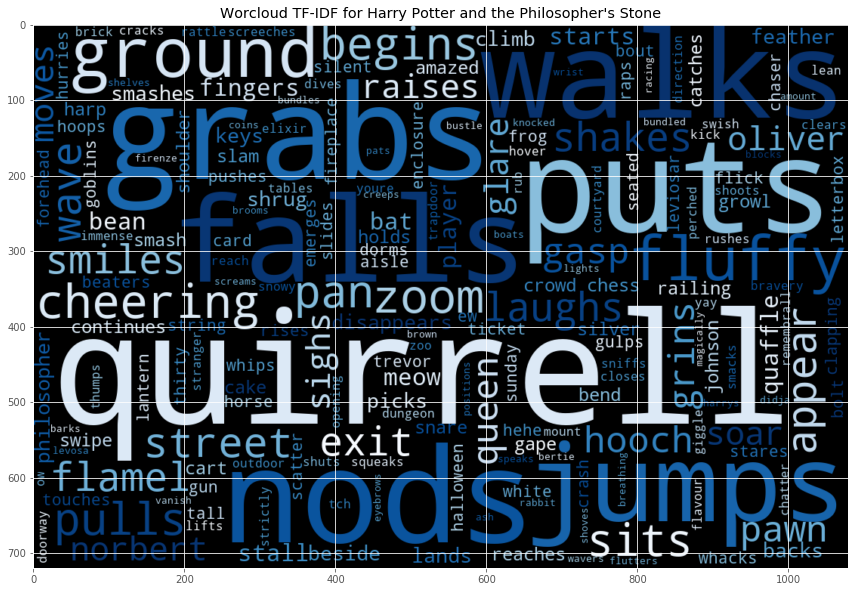

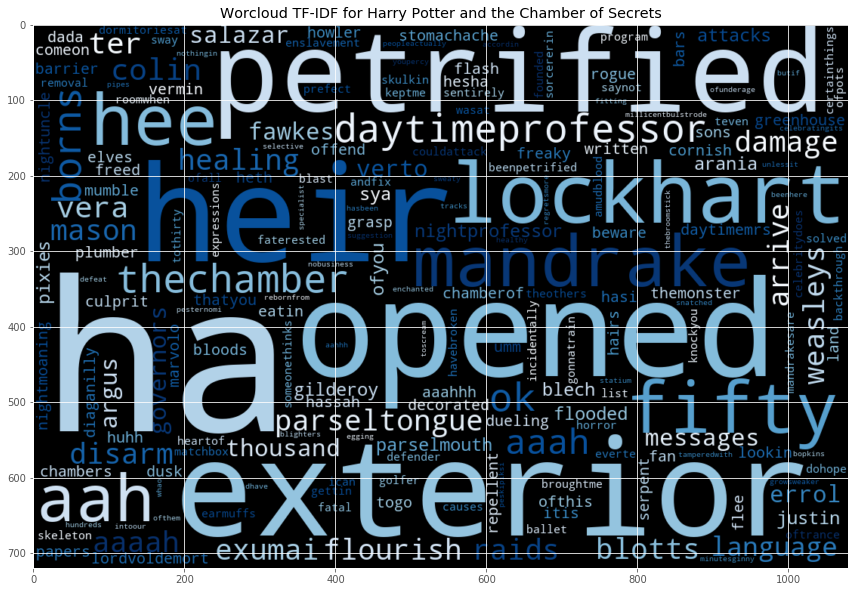

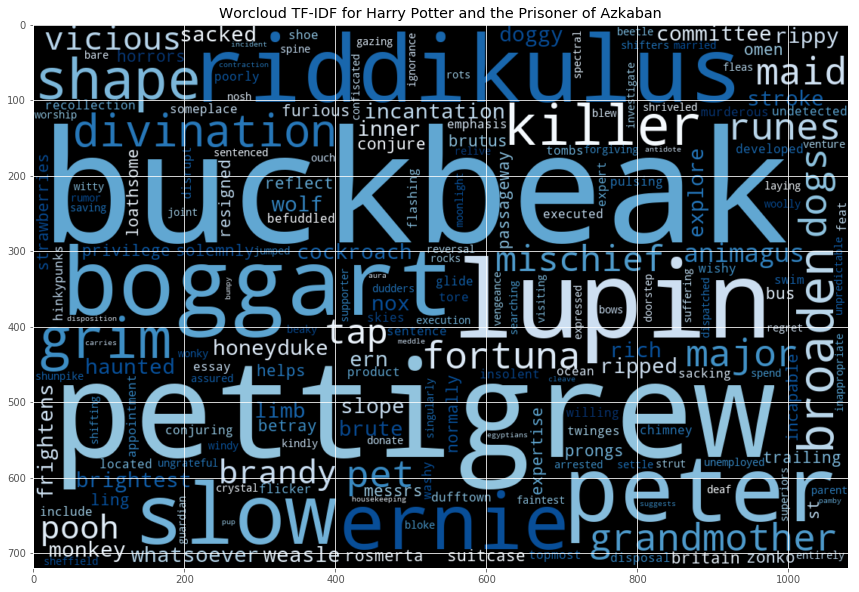

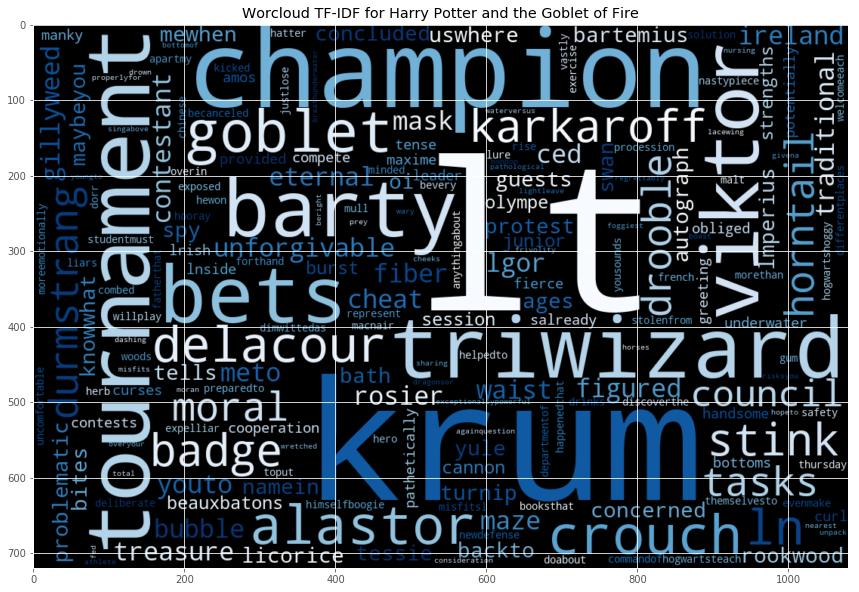

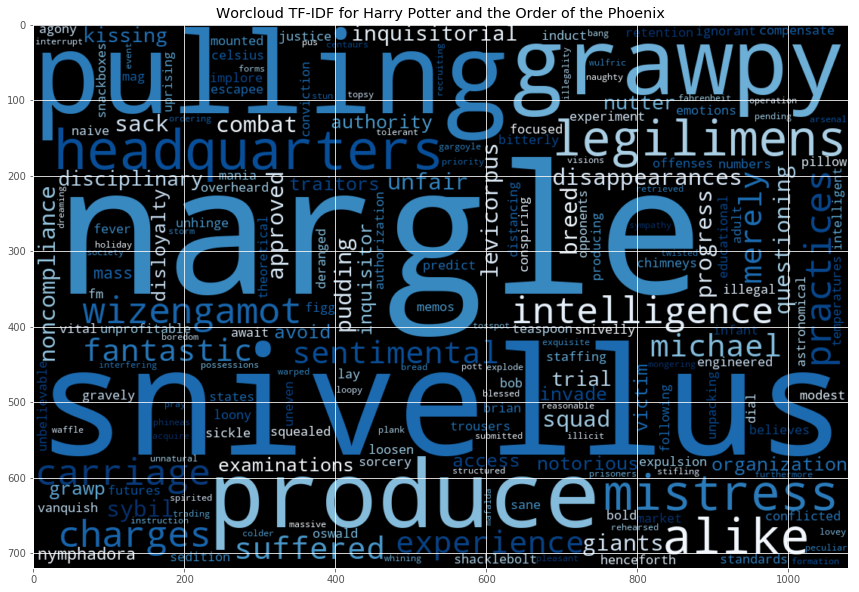

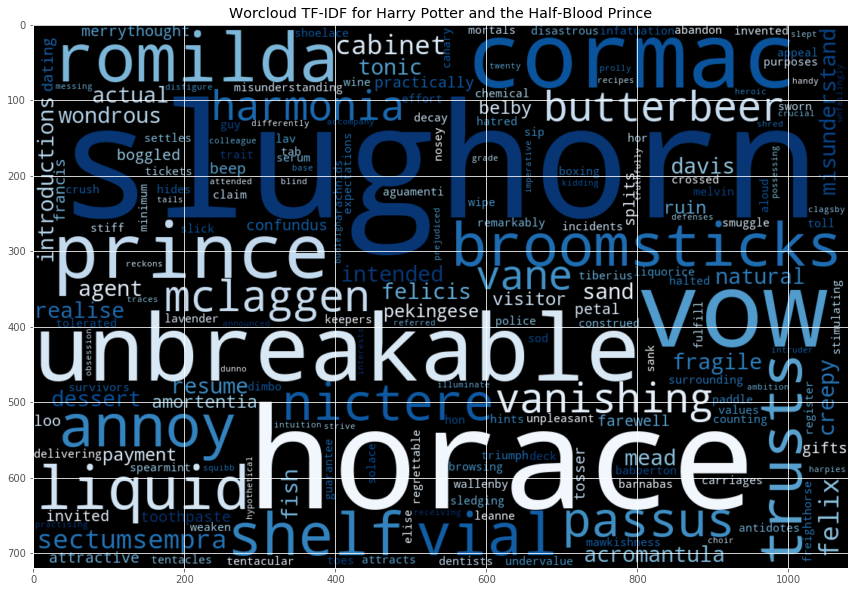

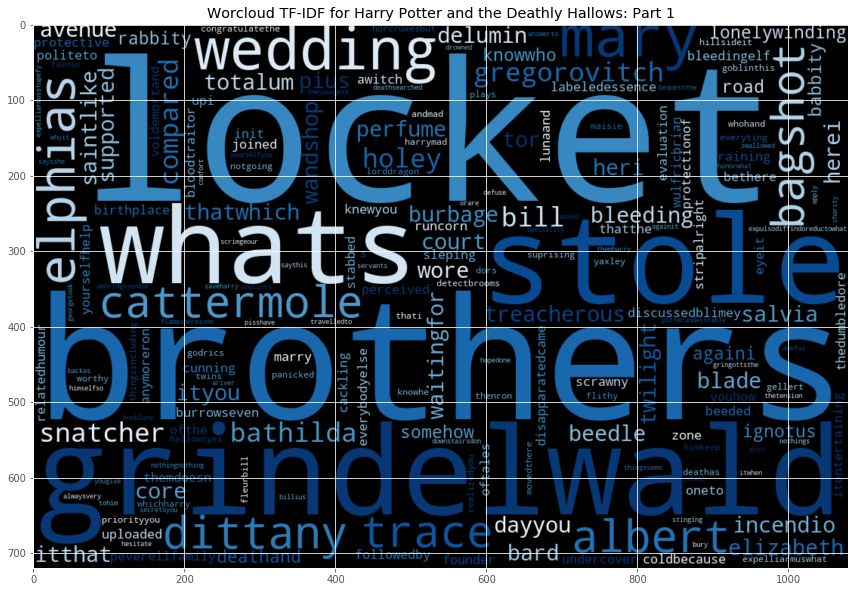

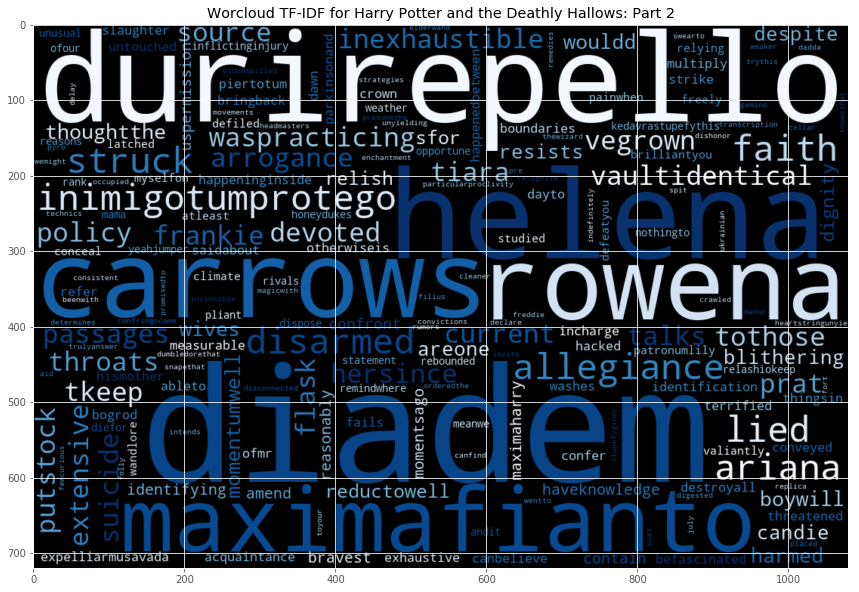

In [14]:
for key in movieTitles:
    collected_list = []
    for key1 in movieTitles:
        if key1 != key:
            collected_list += transcript_dict[key1]
    if "Fantastic Beasts and Where to Find Them" != key:
        draw_word_cloud(transcript_dict[key],collected_list, key)

One thing that beomes very obvious from the wordclouds are the characters only appear in one of the movies. There is quite a few these characters. They are becoming apparent because of the tf-idf. An example could be The Half-blood Prince, where Slughorn is featured as Harry Potters chemistry teacher. In the rest of the movies he is present but never once mentioned again. The same goes for the creature nargle which plays a bit part in the Order of the Phoenix but comes unimportant before and after that movie. 

It is interesting to see that if you have some Harry Potter movie knowledge you could quickly guess from the wordclouds what movie it depicts. This is specifically the tf-idf that makes this easier. 

### Sentiment analysis

Another analysis we want to do for the transcript is looking at how the language changes (or does not) through the movies and if it is possible to might guess event from the transcripts sentiment.

First the sentiment data is loaded in describing the sentiment score for different words.

In [7]:
word_list_df = pd.read_csv('files/Data_Set_S1.txt',delimiter='\t', skiprows=3)
word_list_df.head()

word  happiness_rank  happiness_average  happiness_standard_deviation  \
0   laughter               1               8.50                        0.9313   
1  happiness               2               8.44                        0.9723   
2       love               3               8.42                        1.1082   
3      happy               4               8.30                        0.9949   
4    laughed               5               8.26                        1.1572   

  twitter_rank google_rank nyt_rank lyrics_rank  
0         3600          --       --        1728  
1         1853        2458       --        1230  
2           25         317      328          23  
3           65        1372     1313         375  
4         3334        3542       --        2332

A dictionary is then created holding the word as key and item as the sentiment score. This is to make look up of the words constant.

In [8]:
#Creating dictionary for all words and their happiness average.
happy_dict = {}
for idx, row in word_list_df.iterrows():
    happy_dict[row.word] = row.happiness_average

Below is a method for calculating the sentiment of a tokenized text. All words that are not in the sentiment list of words will not be used.

In [9]:
words = set(word_list_df.word)
mean_happniess = np.mean(word_list_df.happiness_average)

def calculate_sentiment(tokens):
    tsum = 0.
    count = 0.
    for t in tokens:
        if t in words:
            tsum += happy_dict[t]
            count += 1
    if tsum == 0:
        return mean_happniess
    return tsum/count

Here we got thorugh the transcripts. We do not make a point for every word in the transcipt because that would make and unreadable plot. Instead we split on every 6 line, so we take about 6 sentences at a time and use as a point on the plot. There is one movie "Harry Potter and the Half-Blood Prince" where the transcript is not seperated by newlines, but everything is written as one large text. Here we chose to take 30 words at a time and calculating the sentiment for these words as one and count them as a point. 

In [10]:
# Create and entry in the dictionary for each movie
sentence_dict = {}
for keys, row in transcript_not_clean.iteritems():
    sentence_dict[keys] = []

#We split the tokens in the movies in to smaller parts, to make plots that are not as clutered. We split every 6 sentence.
for keys, row in transcript_not_clean.iteritems():
    if keys == "Harry Potter and the Half-Blood Prince":
        temps = row.split(" ")
        tempList = []
        count = 0
        for temp in temps:
            if count % 30 == 0:
                sentence_dict[keys].append(tempList)
                tempList = []
            tempList += clean_transcripts(temp)
            count += 1
    else:
        temps = row.split("\n")
        tempList = []
        count = 0
        for temp in temps:
            if count % 6 == 0:
                sentence_dict[keys].append(tempList)
                tempList = []
            tempList += clean_transcripts(temp)
            count += 1


All the text has now been split into smaller parts. Now we calculate the sentiment analysis for each of these smaller parts that we use as points.

In [11]:
#The sentiment is calculated for the new generated lists
sentiment_senctences_dict = {}
for keys, row in sentence_dict.iteritems():
    sentiment_senctences_dict[keys] = [calculate_sentiment(sentence) for sentence in row if len(sentence) != 0]

We then use these points to generate the plots seen below for each of the movies.

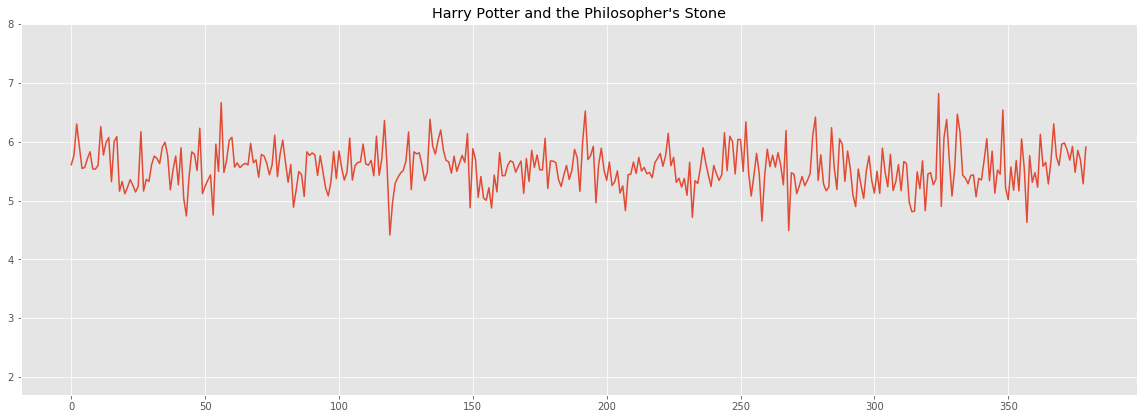

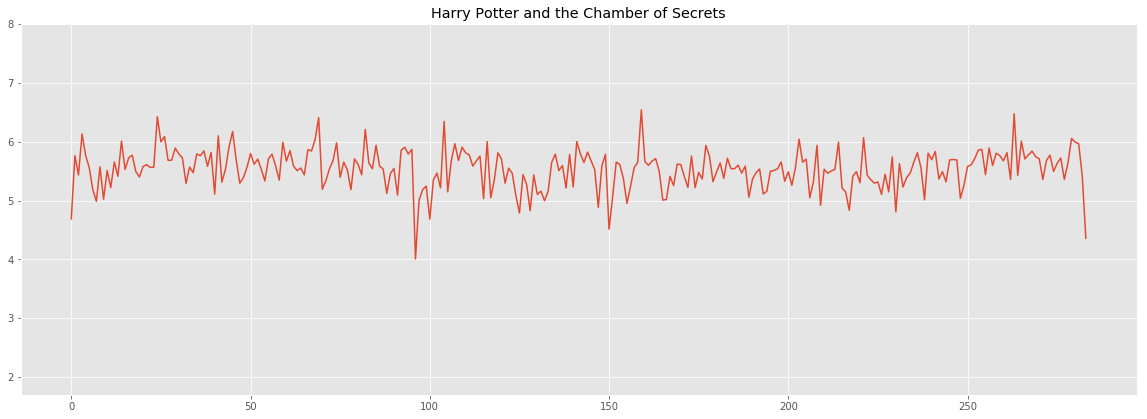

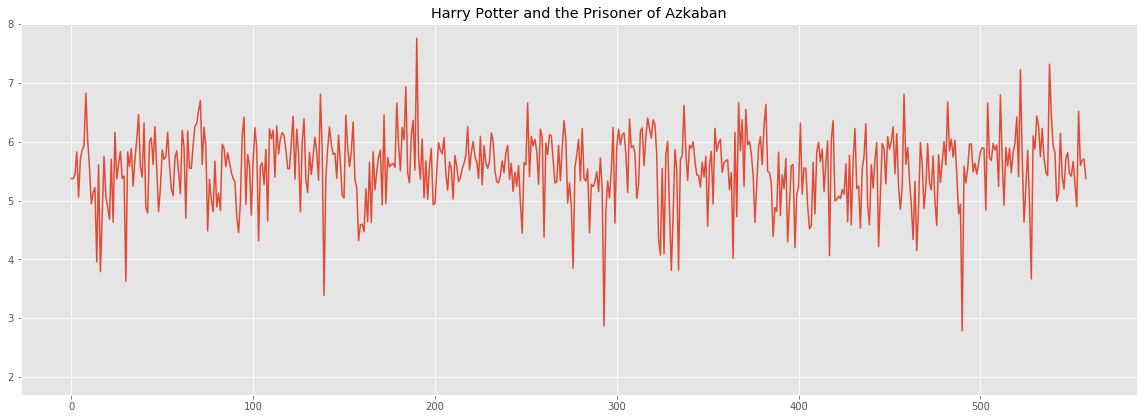

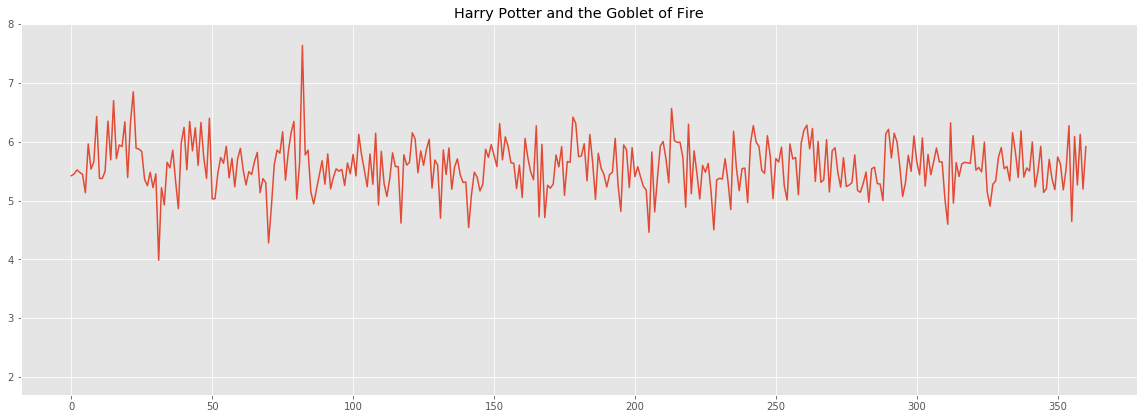

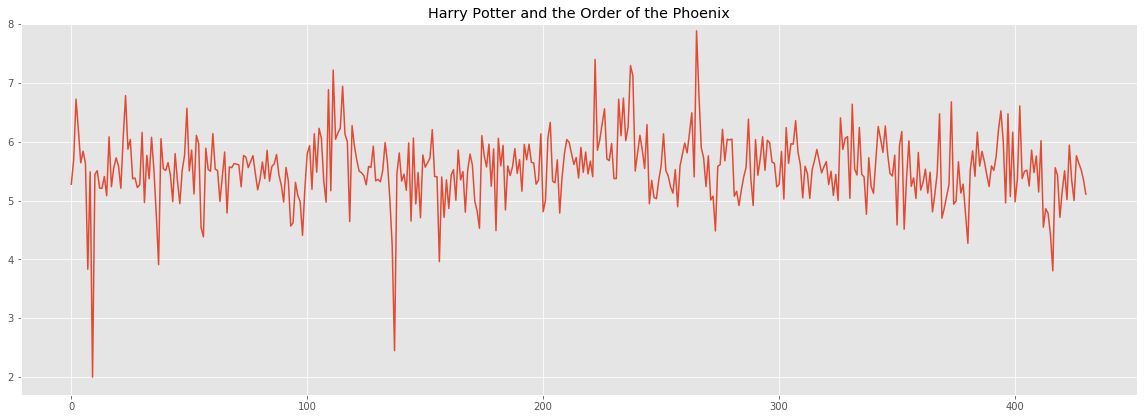

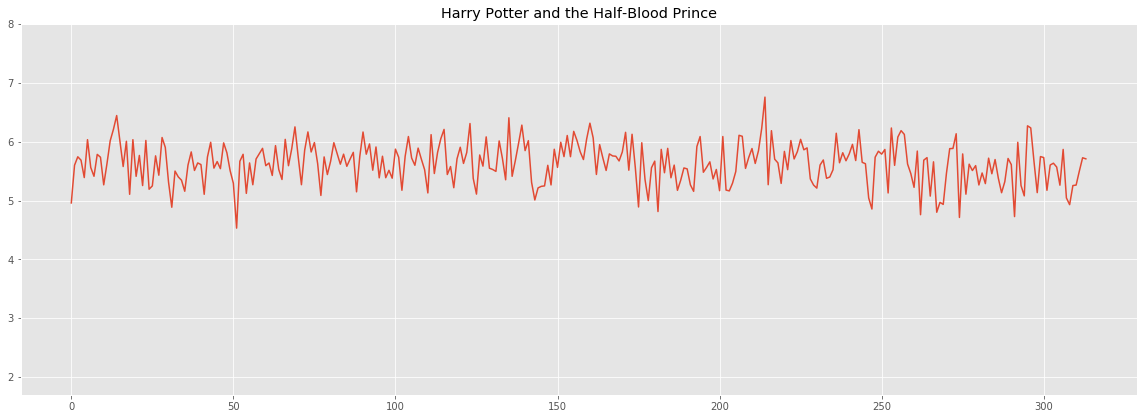

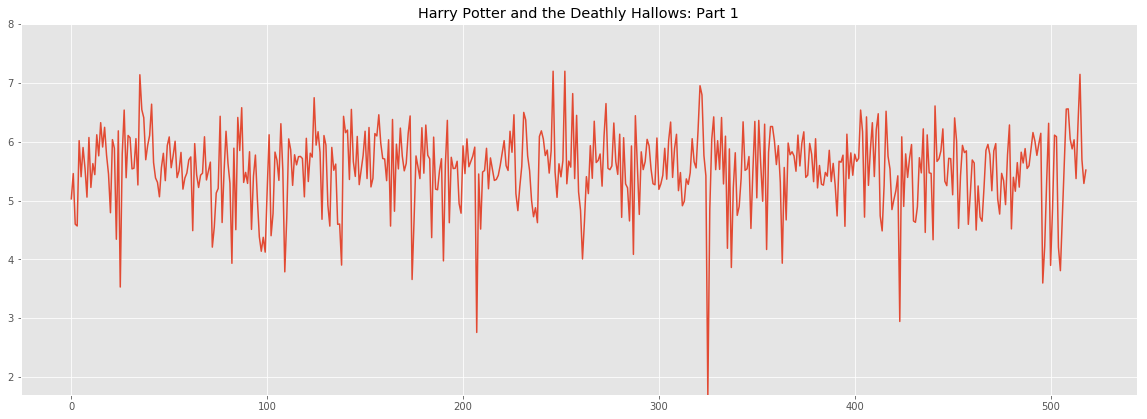

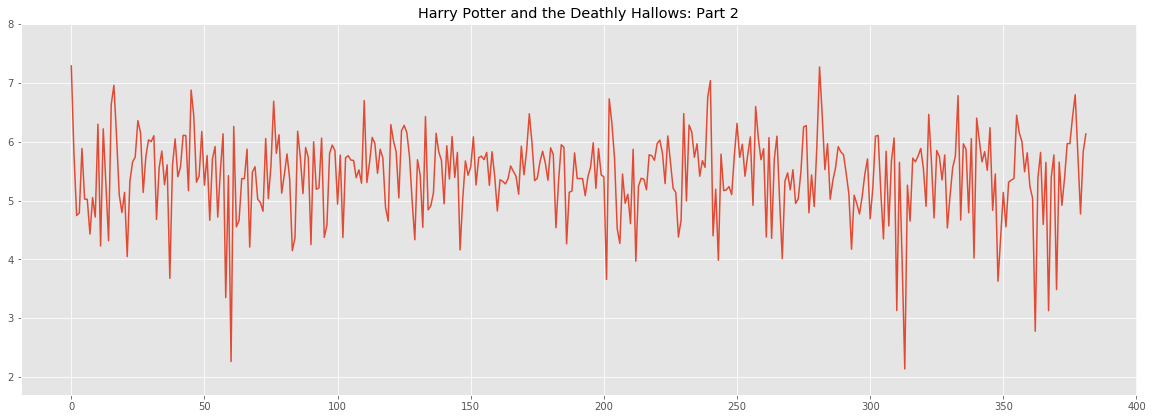

In [15]:
for keys in movieTitles:
    plt.figure(figsize=(20,15))
    plt.subplot(211)
    axes = plt.gca()
    axes.set_ylim([1.7,8])
    plt.plot(range(len(sentiment_senctences_dict[keys])), sentiment_senctences_dict[keys])
    plt.title(keys)

Writing something about the plot.

## Spells

Just as an interesting side analysis we looked at how often are some of the most used spells in the movies actually used.

We did this by first entering all the most common spells in to an array. We then took this array and look through the collected transcripts of all the movies, and saw if the word was present

In [31]:
spells = [
    "riddikulus",
    "obliviate",
    "sectumsempra",
    "avada",
    "alohomora",
    "lumos",
    "expelliarmus",
    "wingardium",
    "accio",
    "expecto",
    "imperio",
    "immobulus",
    "stupefy",
    "incendio",
    "alohomora",
    "apparate",
    "ascendio"
]
numberOfSpells = []
for i in spells:
    numberOfSpells.append(allmovies.count(i))

Now we had all the spells and how many times they were said, and it is then easy to plot is as a bar plot, to show how they relate to each other.

<BarContainer object of 17 artists>

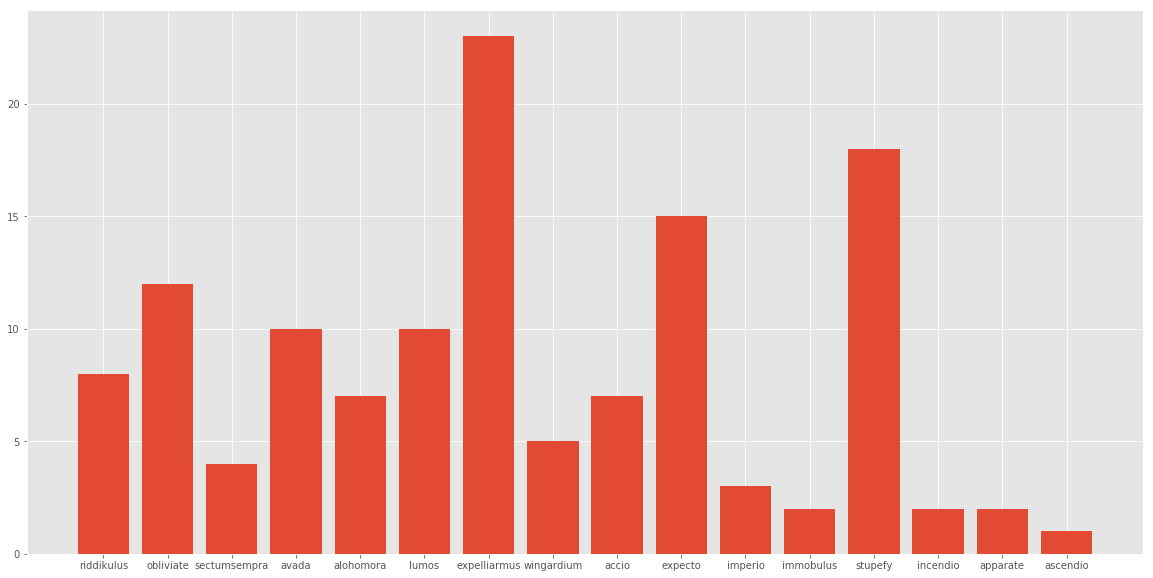

In [40]:
plt.figure(figsize=(20,10))
plt.bar(spells,numberOfSpells)

As can be seen from the bar plot the most used spell in the movies is Expelliaramus. It is the spell that flicks the wand out of a wizards hand practically leaving them defenceless. Another spell that most people know is Wingardium "Leviosa". This spell is actual only used 5 times, and another fun fact is that these 5 times were all in the first movie. 

# 4. Discussion

Discussion. Think critically about your creation
What went well?,
What is still missing? What could be improved?, Why?



